<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Augmentation" data-toc-modified-id="Augmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Augmentation</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pipeline</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Visualize-Training" data-toc-modified-id="Visualize-Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize Training</a></span></li></ul></div>

## Imports

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torchmetrics
import torchvision
from IPython.display import display
from kornia import image_to_tensor, tensor_to_image
from kornia.augmentation import ColorJitter, RandomChannelShuffle, RandomHorizontalFlip, RandomThinPlateSpline
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

sn.set()

## Augmentation

In [3]:
class DataAugmentation(nn.Module):
    """Module to perform data augmentation using Kornia on torch tensors."""

    def __init__(self, apply_color_jitter: bool = False) -> None:
        super().__init__()
        self._apply_color_jitter = apply_color_jitter

        self.transforms = nn.Sequential(
            RandomHorizontalFlip(p=0.75),
            RandomChannelShuffle(p=0.75),
            RandomThinPlateSpline(p=0.75),
        )

        self.jitter = ColorJitter(0.5, 0.5, 0.5, 0.5)

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: Tensor) -> Tensor:
        x_out = self.transforms(x)  # BxCxHxW
        if self._apply_color_jitter:
            x_out = self.jitter(x_out)
        return x_out

In [4]:
class Preprocess(nn.Module):
    """Module to perform pre-process using Kornia on torch tensors."""

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x) -> Tensor:
        x_tmp: np.ndarray = np.array(x)  # HxWxC
        x_out: Tensor = image_to_tensor(x_tmp, keepdim=True)  # CxHxW
        return x_out.float() / 255.0

## Pipeline

In [5]:
class ModelPipeLine(LightningModule):
    def __init__(self, chosen_config):
        super().__init__()
        self.chosen_config = chosen_config
        self.config = self.create_config()
        self.model = self.config["model"]
        self.preprocess = Preprocess()  # per sample transforms
        self.transform = DataAugmentation()  # per batch augmentation_kornia
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, y_hat, y):
        return self.config["loss"](y_hat, y)

    def show_batch(self, win_size=(10, 10)):
        def _to_vis(data):
            return tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

        # get a batch from the training set: try with `val_datlaoader` :)
        imgs, labels = next(iter(self.train_dataloader()))
        imgs_aug = self.transform(imgs)  # apply transforms
        # use matplotlib to visualize
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs))
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs_aug))

    def on_after_batch_transfer(self, batch, dataloader_idx):
        x, y = batch
        if self.trainer.training:
            x = self.transform(x)  # => we perform GPU/Batched data augmentation
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.train_accuracy.update(y_hat, y)
        self.log("train_loss", loss, prog_bar=False)
        self.log("train_acc", self.train_accuracy, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.val_accuracy.update(y_hat, y)
        self.log("valid_loss", loss, prog_bar=False)
        self.log("valid_acc", self.val_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = self.config["optimizer"](self.model.parameters(), lr=1e-4)
        scheduler = self.config["scheduler"](optimizer, self.trainer.max_epochs, 0)
        return [optimizer], [scheduler]

    def prepare_data(self):
        CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)

    def train_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=self.config["train_bs"], num_workers=12)
        return loader

    def val_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=self.config["val_bs"], num_workers=12)
        return loader
    
    def create_config(self):
        dict_configurations = {
            "resnet18_base_test": {
                "model" : torchvision.models.resnet18(pretrained=True),
                "loss" : F.cross_entropy,
                "optimizer" : torch.optim.AdamW,
                "scheduler" : torch.optim.lr_scheduler.CosineAnnealingLR,
                "train_bs" : 256,
                "val_bs" : 256,
            },
        }

        return dict_configurations[self.chosen_config]

## Training

In [6]:
model = ModelPipeLine("resnet18_base_test")

/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# model.show_batch(win_size=(5, 5))

In [10]:
trainer = Trainer(
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
    precision=16,
)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(model)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 11.7 M
1 | preprocess     | Preprocess       | 0     
2 | transform      | DataAugmentation | 0     
3 | train_accuracy | Accuracy         | 0     
4 | val_accuracy   | Accuracy         | 0     
----------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
23.379    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Visualize Training

,train_loss,valid_loss,valid_acc
epoch,,,
0,1.269806,NaN,NaN
0,1.220267,NaN,NaN
0,1.042248,NaN,NaN
0,1.084016,NaN,NaN
0,1.085718,NaN,NaN


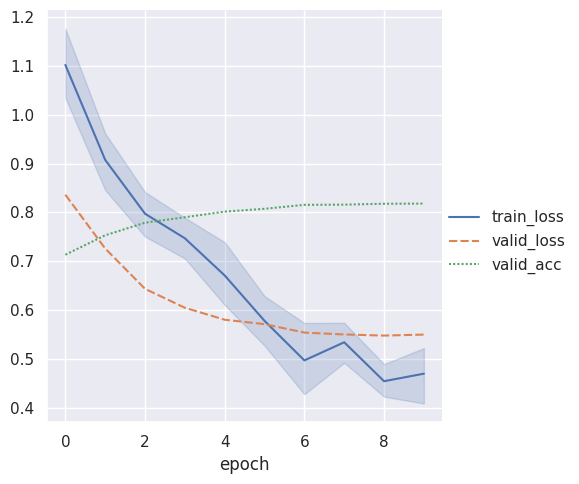

In [12]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")